# EEG data analysis notebook

In [1]:
from util import *

import numpy as np

import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Qt5Agg')

import ipywidgets as widgets

mne.sys_info()

Platform             Windows-10-10.0.22621-SP0
Python               3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:47:18) [MSC v.1916 64 bit (AMD64)]
Executable           c:\Users\zcc\Anaconda3\envs\python3.11\python.exe
CPU                  Intel64 Family 6 Model 151 Stepping 2, GenuineIntel (20 cores)
Memory               15.7 GB

Core
├☑ mne               1.5.1
├☑ numpy             1.25.2 (MKL 2023.1-Product with 12 threads)
├☑ scipy             1.11.3
├☑ matplotlib        3.7.1 (backend=module://matplotlib_inline.backend_inline)
├☑ pooch             1.8.0
└☑ jinja2            3.1.2

Numerical (optional)
├☑ sklearn           1.3.2
├☑ nibabel           5.1.0
├☑ cupy              12.2.0
├☑ pandas            2.1.1
└☐ unavailable       numba, nilearn, dipy, openmeeg

Visualization (optional)
├☑ pyvista           0.42.3 (OpenGL 4.5.0 NVIDIA 536.40 via NVIDIA GeForce RTX 3060/PCIe/SSE2)
├☑ pyvistaqt         0.0.0
├☑ vtk               9.2.6
├☑ qtpy              2.4.1 (PyQt5=5

## Parameter

In [2]:
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = Path(fs_dir).parent

# The files live in:
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src = Path(fs_dir, "bem", "fsaverage-ico-5-src.fif")
bem = Path(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")

0 files missing from root.txt in C:\Users\zcc\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\zcc\mne_data\MNE-fsaverage-data\fsaverage


In [3]:
# mne.viz.set_3d_backend('notebook')
mne.viz.set_3d_backend('pyvistaqt')
print(f'3d backend is using: {mne.viz.get_3d_backend()}')

channel_types_mapping = dict(
    HEO='eog',
    VEO='eog'
)

epochs_crop = dict(
    tmin=-0.2,
    tmax=1.0
)

filter_setup = dict(
    l_freq=0.1,
    h_freq=8.0,
    n_jobs=16
)

n_jobs = 8


Using pyvistaqt 3d backend.



3d backend is using: pyvistaqt

## Methods

In [4]:
def set_montage(raw):
    '''
    Set the montage to the standard_1020,
    and convert the sensor's name into upper case.
    '''
    montage = mne.channels.make_standard_montage('standard_1020')

    names = montage.ch_names
    for n in names:
        montage.rename_channels({n: n.upper()})
    montage.rename_channels({'O9': 'CB1', 'O10': 'CB2'})

    raw.set_montage(montage, on_missing='warn')

## Select EEG data

In [5]:
cnts = [e for e in PPATH.data.iterdir() if e.name.endswith('.cnt')]
print(cnts)

cnt_selector = widgets.Dropdown(
    options=cnts,
    description='Select .cnt file',
    index=3
)

cnt_selector

[
    WindowsPath('D:/suyuan/data/data-1.cnt'),
    WindowsPath('D:/suyuan/data/data-2.cnt'),
    WindowsPath('D:/suyuan/data/data-3.cnt'),
    WindowsPath('D:/suyuan/data/data-4.cnt'),
    WindowsPath('D:/suyuan/data/data-5.cnt'),
    WindowsPath('D:/suyuan/data/data-6.cnt')
]

Dropdown(description='Select .cnt file', index=3, options=(WindowsPath('D:/suyuan/data/data-1.cnt'), WindowsPa…

## Data prepare

### Sensors

In [24]:
source_space = mne.read_source_spaces(src)

# source_space.plot(skull=['inner_skull', 'outer_skull'])
source_space.plot()
print('!!! The result is on the pop-up pyvistaqt window')


    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read


!!! The result is on the pop-up pyvistaqt window

Using D:\suyuan\data\data-4.cnt

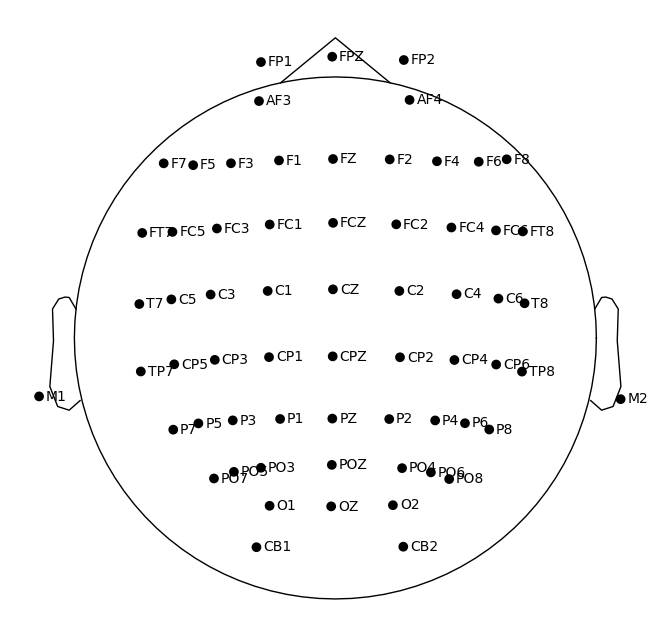

Reading C:\Users\zcc\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Using outer_skin.surf for head surface.
Channel types::	eeg: 64
Projecting sensors to the head surface


!!! The result is on the pop-up pyvistaqt window

In [15]:
cnt_file = cnts[cnt_selector.index]
print(f'Using {cnt_file}')

raw = mne.io.read_raw_cnt(cnt_file)

# Set channel types
try:
    raw.set_channel_types(channel_types_mapping)
except Exception:
    pass

set_montage(raw)

mne.viz.plot_sensors(raw.info, show_names=True)
plt.show()


# Check that the locations of EEG electrodes is correct with respect to MRI
# Only works in cli mode
try:
    fig = mne.viz.plot_alignment(
        raw.info,
        src=src,
        eeg=["original", "projected"],
        trans=trans,
        show_axes=True,
        mri_fiducials=True,
        interaction='trackball',
        dig="fiducials",
    )
    print('!!! The result is on the pop-up pyvistaqt window')
except Exception:
    import traceback
    traceback.print_exc()
    pass

### Events

Events: 16 序列开始，20 序列结束，1 目标，2 非目标，3 被试发现目标按键

Used Annotations descriptions: ['1', '110', '16', '2', '20', '3']


<RawCNT | data-4.cnt, 66 x 426240 (426.2 s), ~81 kB, data not loaded>

[[ 41324      0      2]
 [ 60124      0      3]
 [ 61128      0      4]
 ...
 [406003      0      4]
 [406105      0      4]
 [406670      0      5]]

{'1': 1, '110': 2, '16': 3, '2': 4, '20': 5, '3': 6}

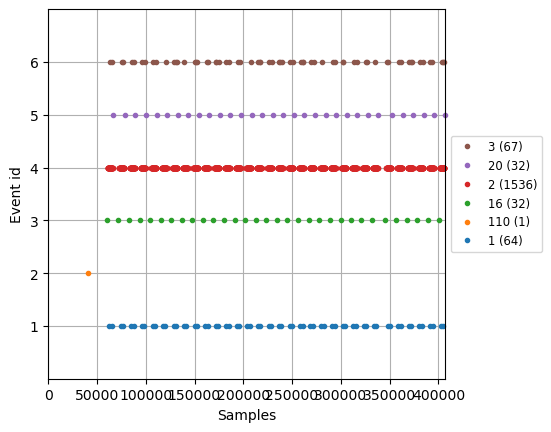

In [7]:
# Events
print('Events:', '16 序列开始，20 序列结束，1 目标，2 非目标，3 被试发现目标按键')

events, event_id = mne.events_from_annotations(raw)
print(raw)
print(events)
print(event_id)

mne.viz.plot_events(events, event_id=event_id)
plt.show()

### Raw denoising (ICA)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


C:\Users\zcc\AppData\Local\Temp\ipykernel_49108\2177884337.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 20 components
Fitting ICA took 9.2s.


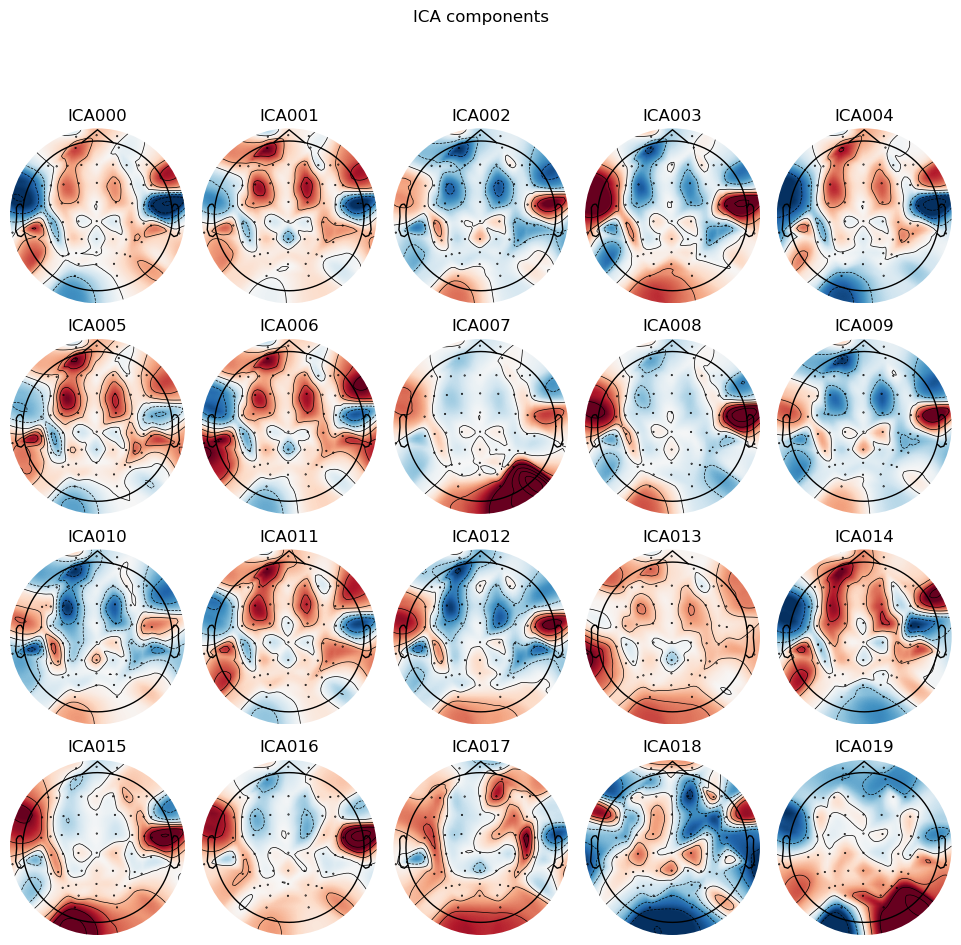

Using EOG channels: HEO, VEO
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Reading 0 ... 426239  =      0.000 ...   426.239 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


<RawCNT | data-4.cnt, 66 x 426240 (426.2 s), ~214.7 MB, data loaded>

In [8]:
ica = mne.preprocessing.ICA(n_components=20)
ica.fit(raw)
ica.plot_components()
plt.show()

eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude += eog_indices
raw.load_data()
ica.apply(raw)

## Epochs

Not setting metadata
1732 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Using data from preloaded Raw for 64 events and 1201 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 0.1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 33001 samples (33.001 s)



C:\Users\zcc\AppData\Local\Temp\ipykernel_49108\1289289086.py:7: RuntimeWarning: filter_length (33001) is longer than the signal (1201), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(**filter_setup)
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 2112 tasks      | elapsed:    2.6s


NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=16)]: Done 4096 out of 4096 | elapsed:    3.4s finished


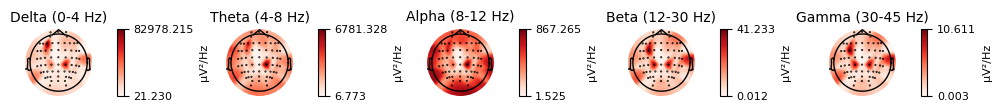

In [9]:
epochs = mne.Epochs(raw, events=events, event_id=event_id,
                    baseline=(None, 0),
                    picks=['eeg'], **epochs_crop)
epochs.set_eeg_reference(projection=True)
epochs = epochs['1']
epochs.load_data()
epochs.filter(**filter_setup)
epochs.plot_psd_topomap(size=2)
plt.show()

## Evoked

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<Evoked | '1' (average, N=64), -0.2 – 1 s, baseline -0.2 – 0 s, 64 ch, ~682 kB>

Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


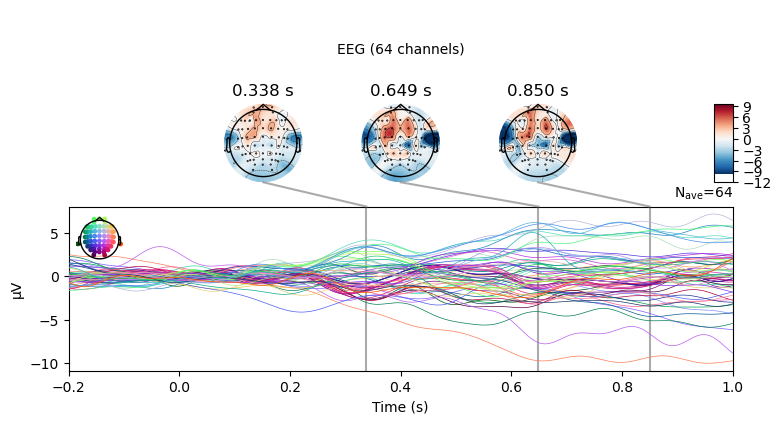

In [10]:
evoked = epochs.average()
print(evoked)
evoked.plot_joint()
plt.show()

## Source analysis

### Compute fwd

In [11]:
fwd = mne.make_forward_solution(
    raw.info, trans=trans, src=src, bem=bem, eeg=True, n_jobs=n_jobs)
print(fwd)

Source space          : C:\Users\zcc\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\zcc\Anaconda3\envs\python3.11\Lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\zcc\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\zcc\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM m

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 1625.0 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.5s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 575.2 ms

Setting up for EEG...


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.2s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished



Finished.


<Forward | MEG channels: 0 | EEG channels: 64 | Source space: Surface with 20484 vertices | Source orientation: 
Free>

### Compute cov, inv, stc

In [12]:
cov = mne.compute_covariance(epochs)
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov)
stc = mne.minimum_norm.apply_inverse(evoked, inv)
vlim = (np.min(stc.data), np.max(stc.data))

print(cov)
print(inv)
print(stc)
print(vlim)

Computing rank from data with rank=None
    Using tolerance 1.1e-10 (2.2e-16 eps * 64 dim * 7.8e+03  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 76864
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.187170
    scale = 122173 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening 

<Covariance | size : 64 x 64, n_samples : 76863, data : [[ 3.96270769e-11  3.30982830e-11  2.61193022e-11 ... 
-3.31188853e-12
  -1.38872478e-11 -7.94919223e-12]
 [ 3.30982830e-11  3.67331692e-11  3.10334042e-11 ... -4.87131247e-12
  -1.28095067e-11 -7.33731237e-12]
 [ 2.61193022e-11  3.10334042e-11  3.09886431e-11 ... -3.39499328e-12
  -1.08072193e-11 -5.26873682e-12]
 ...
 [-3.31188853e-12 -4.87131247e-12 -3.39499328e-12 ...  6.86298700e-11
   1.30846462e-11  2.22746843e-11]
 [-1.38872478e-11 -1.28095067e-11 -1.08072193e-11 ...  1.30846462e-11
   2.82446810e-11  1.10546476e-11]
 [-7.94919223e-12 -7.33731237e-12 -5.26873682e-12 ...  2.22746843e-11
   1.10546476e-11  5.63400167e-11]]>

<InverseOperator | MEG channels: 0 | EEG channels: 64 | Source space: surface with 20484 sources | Source 
orientation: Loose (0.2)>

<SourceEstimate | 20484 vertices, subject : fsaverage, tmin : -200.0 (ms), tmax : 1000.0 (ms), tstep : 1.0 (ms), 
data shape : (20484, 1201), ~187.8 MB>

(0.0015924291387275813, 4.931877294818003)

### Display stc

In [13]:
brain = stc.plot(hemi="both")
brain.add_annotation("HCPMMP1_combined", borders=1)

brain.save_movie(filename='movie.mp4',
                 time_dilation=5,
                 tmin=evoked.tmin,
                 tmax=evoked.tmax,
                 interpolation='linear',
                 framerate=10)

print('!!! The result is on the pop-up pyvistaqt window')

Using control points [2.38549844 2.62652425 4.15815229]


!!! The result is on the pop-up pyvistaqt window

<video src="./movie.mp4" controls autoplay loop>
</video>

### Display stc (flat)

In [14]:
initial_time = 0.1

# stc_fs = mne.compute_source_morph(
#     stc, subject, "fsaverage", subjects_dir, smooth=5, verbose="error"
# ).apply(stc)

brain = stc.plot(
    subjects_dir=subjects_dir,
    initial_time=initial_time,
    # clim=dict(kind="value", lims=[2, 3, 5]),
    surface="flat",
    hemi="both",
    # size=(1000, 500),
    smoothing_steps=5,
    # time_viewer=False,
    add_data_kwargs=dict(colorbar_kwargs=dict(label_font_size=10)),
)

# to help orient us, let's add a parcellation (red=auditory, green=motor,
# blue=visual)
brain.add_annotation("HCPMMP1_combined", borders=1)

# You can save a movie like the one on our documentation website with:
brain.save_movie(filename='movie-flat.mp4',
                 time_dilation=5,
                 tmin=evoked.tmin,
                 tmax=evoked.tmax,
                 interpolation='linear',
                 framerate=10)

print('!!! The result is on the pop-up pyvistaqt window')

Using control points [2.38549844 2.62652425 4.15815229]


!!! The result is on the pop-up pyvistaqt window

<video src="./movie-flat.mp4" controls autoplay loop>
</video>